<a href="https://colab.research.google.com/github/stavco9/datastreaming-final-project/blob/main/Data_Analysis_CMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install mmh3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 2.1 MB/s eta 0:00:00


In [4]:
import bs4
import requests
import json
import time
import sys
import pandas as pd
from random import shuffle

In [3]:
!git clone https://github.com/stavco9/datastreaming-final-project.git

Cloning into 'datastreaming-final-project'...
remote: Enumerating objects: 473, done.
remote: Counting objects: 100% (322/322), done.
remote: Compressing objects: 100% (304/304), done.
remote: Total 473 (delta 77), reused 233 (delta 16), pack-reused 151
Receiving objects: 100% (473/473), 149.16 MiB | 21.10 MiB/s, done.
Resolving deltas: 100% (144/144), done.
Updating files: 100% (176/176), done.


In [8]:
sys.path.insert(1, './datastreaming-final-project/modules')
from CountMinSketch.count_min_sketch2 import CountMinSketch2
from BloomFilter.bloom_filter2 import BloomFilter2
from Dataset.dataset import Dataset

In [10]:
ds = Dataset(links_base_url='https://en.wikipedia.org/wiki/',
             links_uri='Wikipedia:Good_articles/By_length',
             links_column='Article')

words_list_per_article = ds.build_words_list(num_of_articles = 20)
words_list = []
for article in list(words_list_per_article.values()):
      words_list.extend(article)

In [11]:
len(words_list)

364977

In [12]:
NUM_COUNTERS = 300000
NUM_HASH_FUNCTIONS = 100
cms = CountMinSketch2(buckets=NUM_COUNTERS, tables=NUM_HASH_FUNCTIONS)

for word in words_list:
    cms.increment(word)

In [13]:
n = len(words_list) #no of items to add
p = 0.01 #false positive probability
bloomf = BloomFilter2(n,p)

for word in words_list:
    bloomf.add(word)

In [14]:
correct_sentence = "I wanna apple please or a banana with a pear and a lemon, \
  or a watermelon if possible. I hope i don't have an error in London and in Jerusalem".split()

In [15]:
print("Measuring CMS vs Naive")

time_naive_start = time.time()
counts_naive = pd.Series(
    (words_list.count(x) for x in correct_sentence),
    index=correct_sentence,
).sort_values(ascending=False)
time_naive_end = time.time()

time_cms_start = time.time()
counts_cms = pd.Series(
    (cms.count(x) for x in correct_sentence),
    index=correct_sentence,
).sort_values(ascending=False)
time_cms_end = time.time()

Measuring CMS vs Naive


<Axes: xlabel='cnt_actual', ylabel='cnt_cms'>

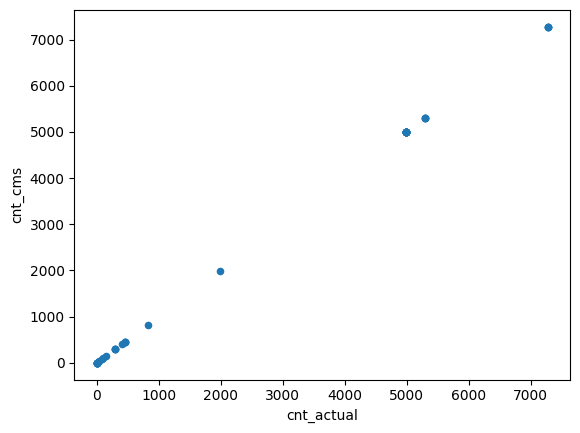

In [16]:
(
    counts_cms.to_frame('cnt_cms')
    .reset_index()
    .merge(
        counts_naive
        .to_frame('cnt_actual')
        .reset_index()
    ).set_index('index')
).plot.scatter(x='cnt_actual', y='cnt_cms')

In [17]:
df_diff = counts_naive.compare(counts_cms)
df_diff

,self,other


In [18]:
df_all = counts_naive.compare(counts_cms, keep_shape=True, keep_equal=True)
df_all

,self,other
and,7278,7278.0
and,7278,7278.0
in,5302,5302.0
in,5302,5302.0
a,4992,4992.0
a,4992,4992.0
a,4992,4992.0
a,4992,4992.0
with,1987,1987.0
an,820,820.0


In [19]:
diff_count = len(df_diff)
error_rate = diff_count / len(counts_naive)
print(f"Error rate is {error_rate}")

Error rate is 0.0


In [20]:
print(f"Total time naive: {time_naive_end - time_naive_start}s")
print(f"Total time cms: {time_cms_end - time_cms_start}s")

Total time naive: 0.7331972122192383s
Total time cms: 0.004558086395263672s
